## Example of metric calculation using moving object metrics.

The inputs needed here (the obsfile) can be calculated using the code demonstrated in the [ExampleMoObs](./ExampleMoObs.ipynb) notebook. 

Here, I'm working through how those observations can be read back into the code and metric values (such as discovery chances and then completeness) can be calculated. 

There are definitely some things to be improved upon; if the observation generation stopped at the point of generating interpolations, for example, and the moving object slicer read those interpolations back in, together with the the simdata, it could generate the actual observations on the fly (when using the camera footprint, this would add non-insignificant overhead, so it might actually be nice to be able to do either/both). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from moSlicer import MoSlicer
import moMetrics as MoMetrics
from moSecondaryMetrics import MoCompletenessMetric, IntegrateOverHMetric, IdentityAtHMetric
import moPlots as moPlots
import moMetricBundle as mmb
import lsst.sims.maf.plots as plots

In [8]:
# Set up MoSlicer.  We use the moving object slicer to read the observation data from disk.
test = False
if test:
    orbitfile = 'test.des'
    obsfile = 'test_out.txt'
    runName = 'enigma_1189'
    metadata = '8 NEOs'
else:
    orbitfile = 'pha20141031.des'
    obsfile = 'pha_withChip_allObs.txt'
    runName = 'enigma_1189'
    metadata = 'PHAS with camera footprint'

In [9]:
mos = MoSlicer(orbitfile, obsfile, Hrange=np.arange(15, 25, 0.5))
print mos.slicePoints['H']
mos.allObs.tail(10)

[ 15.   15.5  16.   16.5  17.   17.5  18.   18.5  19.   19.5  20.   20.5
  21.   21.5  22.   22.5  23.   23.5  24.   24.5]


,objId,delta,ra,dec,magV,time,dradt,ddecdt,phase,solarelon,...,rotSkyPos,filter,finSeeing,fiveSigmaDepth,visitExpTime,solarElong,dmagColor,dmagTrailing,dmagDetect,magFilter
498475,1509,4.196785,229.619349,-13.626155,27.173409,52845.077108,-0.021218,-0.008593,11.969354,109.072978,...,3.935084,i,0.644804,24.092780,30,109.358004,-0.291352,0.000000,0.028169,26.882057
498476,1509,4.401392,229.711592,-13.842703,27.294233,52859.034584,0.028022,-0.021363,12.618674,95.906760,...,3.861676,z,0.675113,22.476600,30,96.033721,-0.298076,0.000000,0.024445,26.996158
498477,1509,4.401616,229.712024,-13.843021,27.294350,52859.049517,0.028214,-0.021317,12.619039,95.892870,...,3.867150,z,0.691151,22.425294,30,96.019335,-0.298076,0.000000,0.024664,26.996275
498478,1509,4.401869,229.712508,-13.843379,27.294482,52859.066293,0.028431,-0.021265,12.619449,95.877267,...,3.843012,z,0.714218,22.354727,30,96.003156,-0.298076,0.000000,0.024977,26.996406
498479,1509,4.402088,229.712930,-13.843691,27.294596,52859.080905,0.028619,-0.021220,12.619806,95.863676,...,3.863833,z,0.739691,22.280524,30,95.989051,-0.298076,0.000000,0.025311,26.996521
498480,1509,4.957783,233.274644,-15.179477,27.481192,52897.977773,0.137054,-0.042954,11.200188,62.071364,...,4.208025,z,0.764811,22.072328,30,61.360249,-0.298076,0.011969,0.007303,27.183116
498481,1509,4.957788,233.274708,-15.179496,27.481193,52897.978220,0.137060,-0.042952,11.200150,62.070992,...,4.244280,z,0.751296,22.094496,30,63.268081,-0.298076,0.012400,0.007168,27.183117
498482,1509,4.958015,233.277193,-15.180251,27.481227,52897.995756,0.137268,-0.042895,11.198672,62.056433,...,4.189117,z,0.804568,23.060499,30,61.342748,-0.298076,0.010844,0.007732,27.183151
498483,1509,4.958020,233.277256,-15.180270,27.481228,52897.996203,0.137273,-0.042893,11.198634,62.056062,...,4.220982,z,0.787290,23.103934,30,63.250525,-0.298076,0.011328,0.007533,27.183152
498484,1509,4.983177,233.568401,-15.267207,27.484497,52899.985661,0.141574,-0.043463,11.022125,60.414681,...,4.251414,y,0.750985,21.349760,30,61.313562,-0.302563,0.013179,0.006962,27.181934


In [10]:
mos.orbits.tail()

,H,M,a,argPeri,e,epoch,g,inc,node,objId,q,tPeri
1505,20,77.366479,0.827048,180.468630,0.261660,49353.16,0.15,18.671330,196.578930,1505,1.043454,49294.121282
1506,20,4110.999168,0.501293,254.126570,0.677470,49353.16,0.15,5.860190,230.397840,1506,0.840904,47872.781068
1507,20,550.437461,0.733294,182.128100,0.324399,49353.16,0.15,40.010180,45.448550,1507,0.971174,49002.478210
1508,20,495.166011,0.325984,286.820640,0.728317,49353.16,0.15,6.578750,6.006240,1508,0.563404,49259.655236
1509,20,2040.128826,0.558708,234.119532,0.667609,49353.16,0.15,4.725926,183.610507,1509,0.931707,48488.743387


In [13]:
# Set up an example metric bundle.
metric = MoMetrics.NObsMetric()
slicer = mos
pandasConstraint = None
if test:
    plotDict = {'nxbins':20, 'nybins':20}
else:
    plotDict = {'nxbins':100, 'nybins':100}
nobs = mmb.MoMetricBundle(metric, slicer, pandasConstraint, 
                          runName=runName, metadata=metadata, plotDict=plotDict)

In [14]:
# Calculate completeness. First we must calculate "DiscoveryChances". 
# Set up an example metric bundle.
metric = MoMetrics.DiscoveryChancesMetric()
slicer = mos
pandasConstraint = None
discovery = mmb.MoMetricBundle(metric, slicer, pandasConstraint, 
                               runName=runName, metadata=metadata, plotDict=plotDict)

In [15]:
# try a different kind of metric, looking at chances of finding activity
metric = MoMetrics.ActivityOverTimeMetric(window=6*30.)
slicer = mos
pandasConstraint = None
activity6month = mmb.MoMetricBundle(metric, slicer, pandasConstraint, 
                               runName=runName, metadata=metadata, plotDict=plotDict)

Calculated all metrics.
Plotted all metrics.


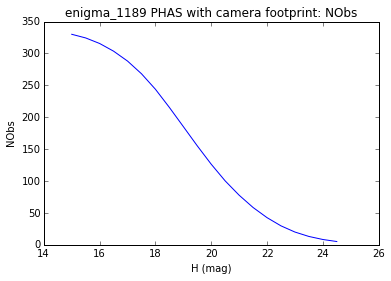

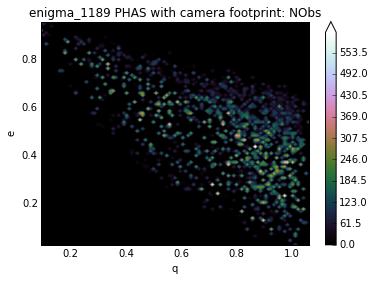

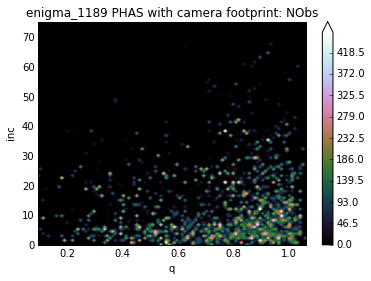

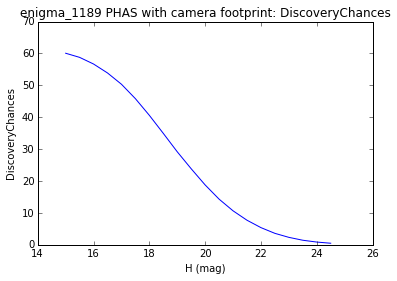

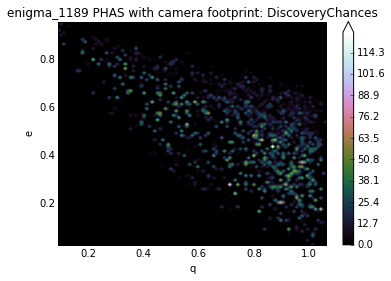

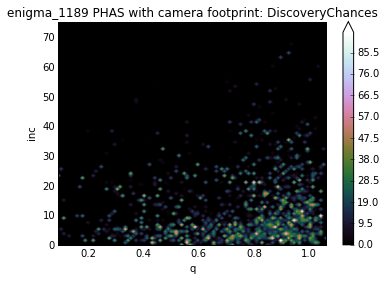

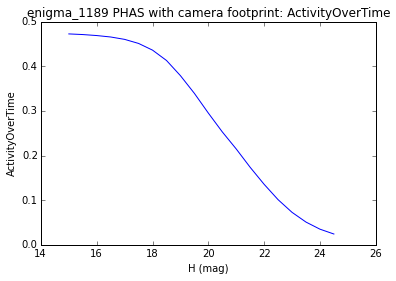

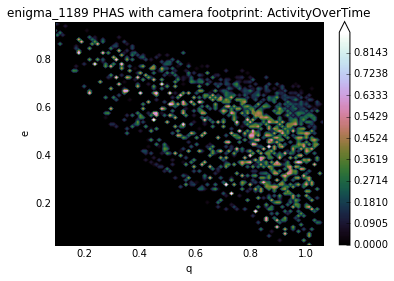

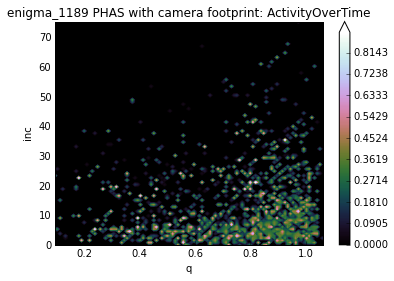

In [16]:
bdict = {'nobs':nobs, 'discovery':discovery, 'activity':activity6month}
bg = mmb.MoMetricBundleGroup(bdict)
bg.runAll()
bg.plotAll()

1

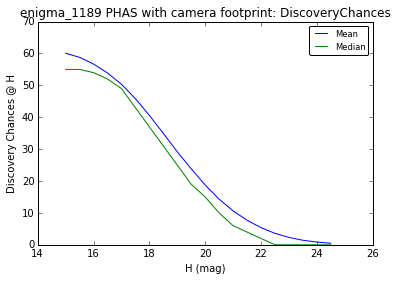

In [17]:
ph = plots.PlotHandler()
ph.setMetricBundles([discovery, discovery])
ph.setPlotDicts([{'npReduce':np.mean, 'color':'b', 'label':'Mean'}, 
                 {'npReduce':np.median, 'color':'g', 'label':'Median'}])
ph.plot(plotFunc=moPlots.MetricVsH(), plotDicts={'ylabel':'Discovery Chances @ H'})

In [18]:
# Then calculate 'completeness' as function of H, as a secondary metric.
completeness = discovery.runSecondaryMetric(MoCompletenessMetric())
print completeness.metricValues.data

[ 0.93311258  0.93311258  0.93311258  0.93311258  0.93311258  0.93245033
  0.93178808  0.92715232  0.91258278  0.89470199  0.85695364  0.80264901
  0.74304636  0.67549669  0.57218543  0.46622517  0.36490066  0.27019868
  0.2         0.13245033]


{'MetricVsH': 1}

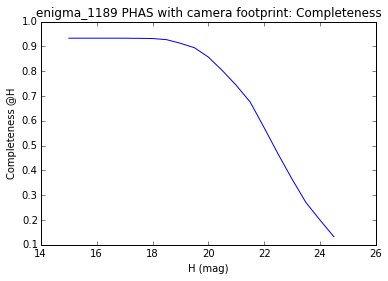

In [19]:
completeness.plot()

{'MetricVsH': 1}

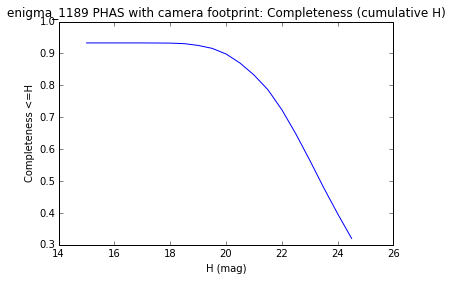

In [20]:
# And we can make an 'integrated over H distribution' version. 
completenessInt = completeness.runSecondaryMetric(IntegrateOverHMetric())
completenessInt.plot()

Found more than one value to be set for "legendloc" in the plotDicts. Will reset to default value
Found more than one value to be set for "legendloc" in the plotDicts. Will reset to default value
Found more than one value to be set for "legendloc" in the plotDicts. Will reset to default value


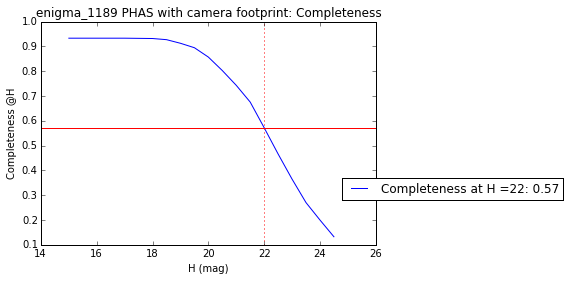

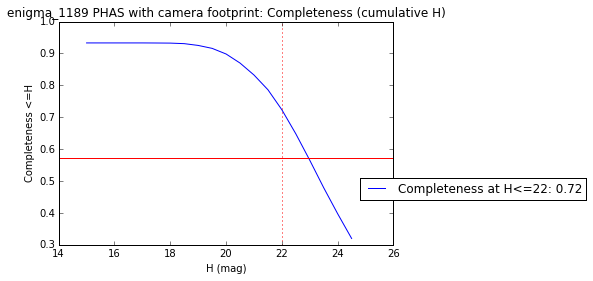

In [45]:
# This needs to be the equivalent of a summary statistic (but calculated at a given H value)
summaryMetric = IdentityAtHMetric(Hmark=22.)
comp = summaryMetric.run(completeness.metricValues, completeness.slicer.slicePoints['H'])
label = "Completeness at H =22: %.2f" %comp
completeness.setPlotDict({'label':label})
compI = summaryMetric.run(completenessInt.metricValues, completeness.slicer.slicePoints['H'])
label = "Completeness at H<=22: %.2f" %compI
completenessInt.setPlotDict({'label':label})

completeness.plot(plotFunc = moPlots.MetricVsH())
plt.axvline(22, color='r', linestyle=':')
plt.axhline(comp, color='r', linestyle='-')
plt.legend(loc=(0.9, 0.2))

completenessInt.plot(plotFunc = moPlots.MetricVsH())
plt.axvline(22, color='r', linestyle=':')
plt.axhline(comp, color='r', linestyle='-')
plt.legend(loc=(0.9, 0.2))

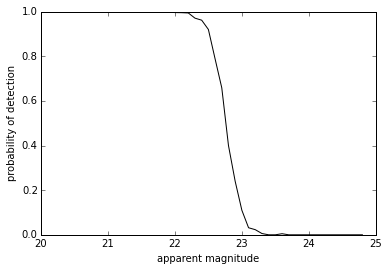

In [46]:
### side note.. illustrating detection probability curve (50% at m5)
# this probability curve is used if snrLimit is NOT set (otherwise it's just a cutoff at snrLimit)
metric = MoMetrics.BaseMoMetric()
# Check what 'visibility' looks like. 
nobjs = 10000
appMag = np.random.rand(nobjs) * 5.0 + 20.0
magLimit = 22.8
vis = metric._calcVis(appMag, magLimit)
bins = np.arange(appMag.min(), appMag.max(), 0.1)
vn, b = np.histogram(appMag[vis], bins=bins)
n, b = np.histogram(appMag, bins=bins)
plt.plot(b[:-1], vn / n.astype(float), 'k-')
plt.xlabel('apparent magnitude')
plt.ylabel('probability of detection')